In [1]:
# Required libraries
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, find_objects, binary_erosion, binary_dilation, distance_transform_edt
from scipy import stats as scipy_stats
from scipy.signal import find_peaks, savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.spatial import Delaunay, distance
from sklearn.cluster import DBSCAN
from skimage import filters
from skimage.filters import threshold_otsu, threshold_multiotsu
import networkx as nx

In [2]:
# Input staleite data, i.e.: https://browser.dataspace.copernicus.eu/
optical_image_path = 'data/gdansk_optical_1.jpg'
sar_image_path = 'data/gdansk_sar_1.jpg'

# Extract base name for input files (without extension)
base_name = os.path.splitext(os.path.basename(optical_image_path))[0].split('_optical')[0]

In [3]:
# Define thresholds for segmentation
water_threshold = 0.4
urban_threshold = 1.25
urban_center_threshold = 1.4

# Define resolution: i.e. 20m per pixel
satellite_pixel_resolution = 20

# Set ticks intervals for different plots
image_x_tick_interval = 5000  # meters (5km)
image_y_tick_interval = image_x_tick_interval  # meters (5km)
gradient_x_tick_interval = 1000  # meters (1km)

In [4]:
# Load and process optical image
optical_image = cv2.imread(optical_image_path)
optical_image_rgb = cv2.cvtColor(optical_image, cv2.COLOR_BGR2RGB)
optical_image_gray = cv2.cvtColor(optical_image, cv2.COLOR_BGR2GRAY)  # Simplified conversion

# Edge detection with Sobel
optical_image_sobelx = cv2.Sobel(optical_image_gray, cv2.CV_64F, 1, 0, ksize=3)
optical_image_sobely = cv2.Sobel(optical_image_gray, cv2.CV_64F, 0, 1, ksize=3)
optical_image_sobel_combined = cv2.magnitude(optical_image_sobelx, optical_image_sobely)
optical_image_sobel_combined = cv2.normalize(optical_image_sobel_combined, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Create edge density map
kernel_size = 15
optical_image_density_map = cv2.GaussianBlur(optical_image_sobel_combined, (kernel_size, kernel_size), 0)
# Fix: Convert to float before normalizing
optical_image_density_map = optical_image_density_map.astype(float) / np.max(optical_image_density_map)

# Load and normalize SAR image
sar_image = cv2.imread(sar_image_path, cv2.IMREAD_GRAYSCALE).astype(float) / 255.0

# Combine images and apply Non-Local Means smoothing
combined_image = optical_image_density_map + sar_image
combined_image_uint8 = np.clip(combined_image * 127.5, 0, 255).astype(np.uint8)
smoothed_image_uint8 = cv2.fastNlMeansDenoising(combined_image_uint8, None, 10, 7, 21)
combined_image = smoothed_image_uint8.astype(float) / 127.5

# Create initial segmentation
segmentation = np.zeros_like(combined_image, dtype=np.uint8)
segmentation[(combined_image < water_threshold)] = 1  # Water
segmentation[(combined_image >= water_threshold) & (combined_image < urban_threshold)] = 2  # Terrain
segmentation[(combined_image >= urban_threshold)] = 3  # Urban

# Process urban mask
urban_mask = (segmentation == 3).astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8)
urban_mask_closed = cv2.morphologyEx(
    cv2.dilate(urban_mask, kernel, iterations=1), 
    cv2.MORPH_CLOSE, 
    kernel
)

# Filter small urban patches
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(urban_mask_closed, connectivity=8)
urban_mask_filtered = np.zeros_like(urban_mask_closed)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= 100:  # min_urban_area = 100
        urban_mask_filtered[labels == i] = 255

# Create final segmentation
improved_segmentation = segmentation.copy()
improved_segmentation[improved_segmentation == 3] = 2  # Reset urban to terrain
improved_segmentation[urban_mask_filtered == 255] = 3  # Set filtered urban areas

# Apply colormap for visualization
colormap = np.array([
    [0, 0, 0],      # Background
    [0, 0, 255],    # Water (blue)
    [0, 255, 0],    # Terrain (green)
    [255, 0, 0]     # Urban (red)
], dtype=np.uint8)
segmented_image = colormap[improved_segmentation]

# Create masks for density analysis
urban_mask = improved_segmentation == 3
urban_density = np.ma.masked_array(combined_image, mask=~urban_mask)
urban_centers_mask = (combined_image > urban_center_threshold) & urban_mask

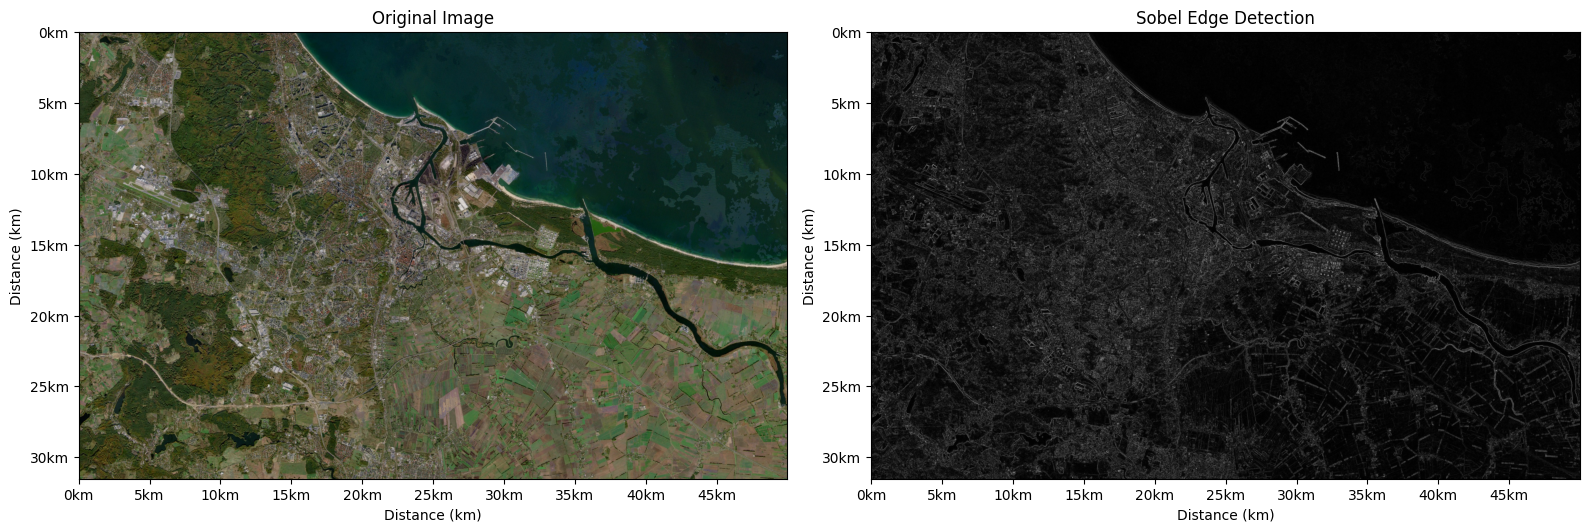

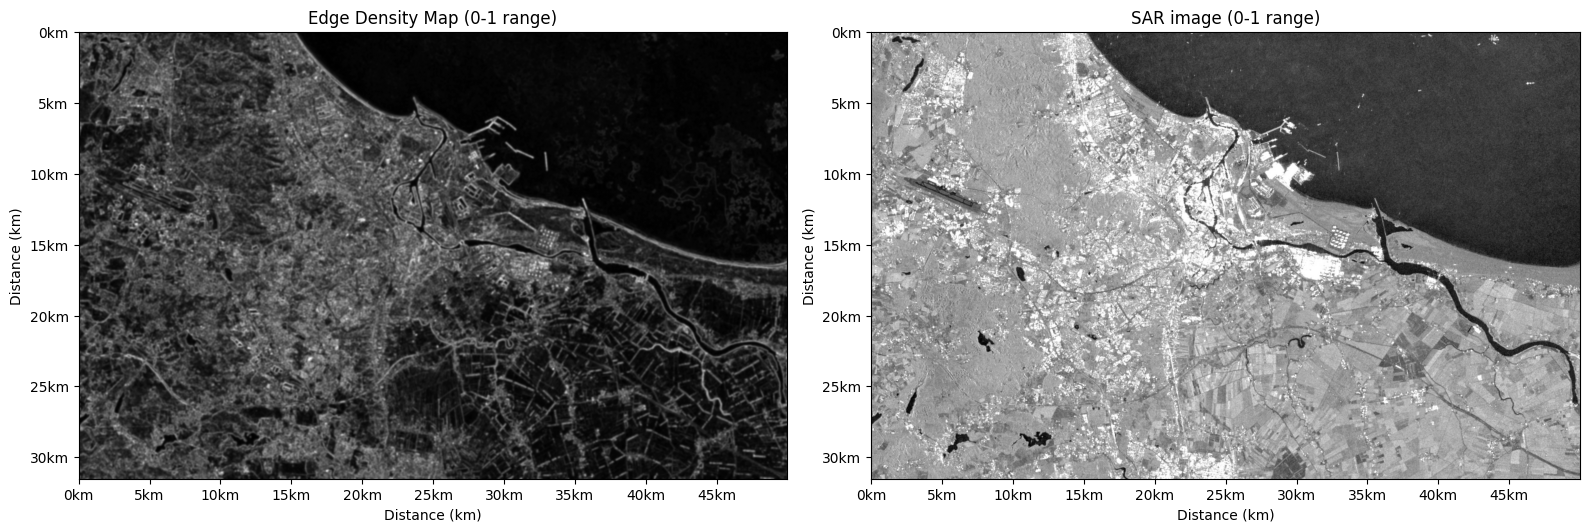

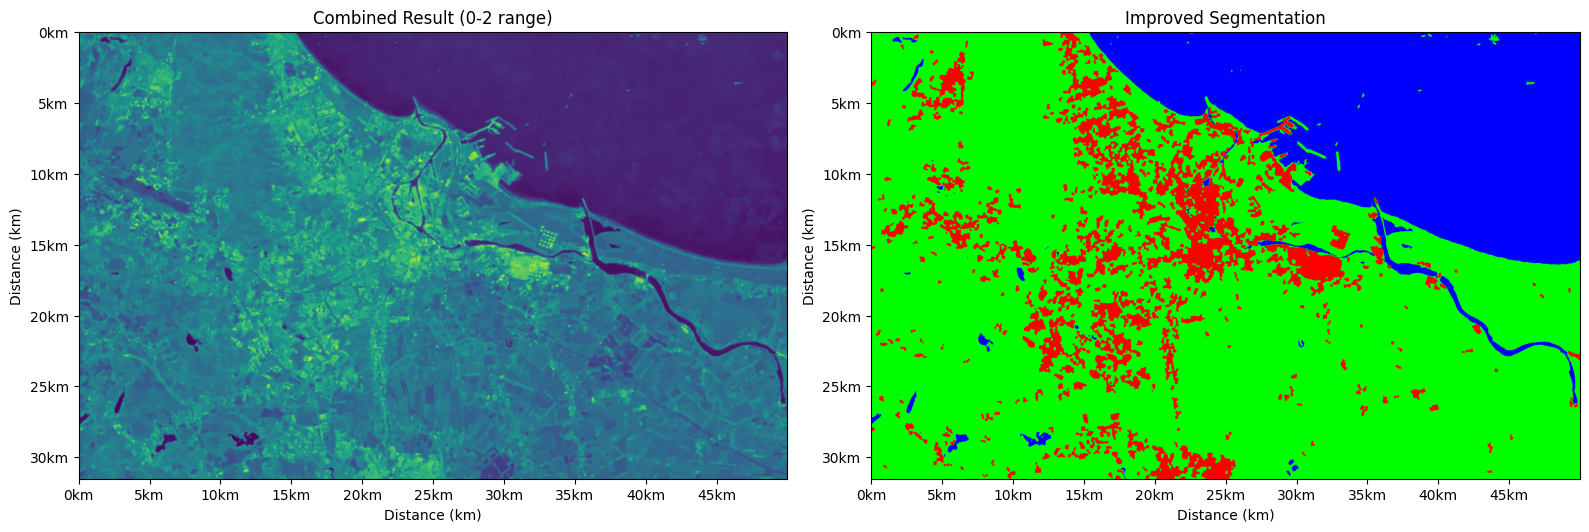

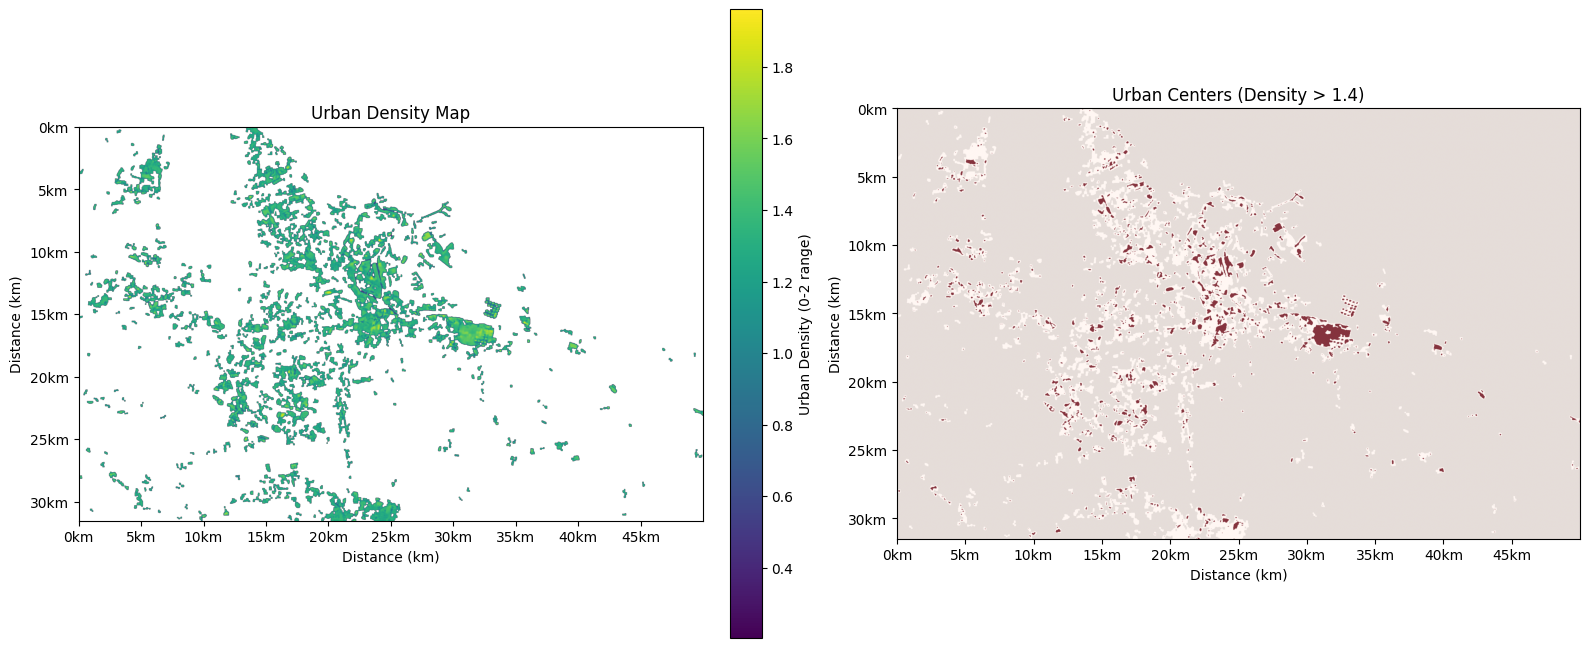

In [5]:
# Function to set axes in meters
def set_axes_in_meters(ax, img_shape):
    height, width = img_shape[:2]
    # Create x and y axes in meters
    x_meters = np.arange(0, width * satellite_pixel_resolution, satellite_pixel_resolution)
    y_meters = np.arange(0, height * satellite_pixel_resolution, satellite_pixel_resolution)
    
    # Set ticks at regular intervals (5km)
    image_x_tick_interval = 5000  # meters (5km)
    image_y_tick_interval = 5000  # meters (5km)
    
    x_ticks = np.arange(0, width * satellite_pixel_resolution, image_x_tick_interval)
    y_ticks = np.arange(0, height * satellite_pixel_resolution, image_y_tick_interval)
    
    ax.set_xticks(x_ticks / satellite_pixel_resolution)
    ax.set_yticks(y_ticks / satellite_pixel_resolution)
    ax.set_xticklabels([f'{int(x/1000)}km' for x in x_ticks])
    ax.set_yticklabels([f'{int(y/1000)}km' for y in y_ticks])
    
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')

# Figure 1: Original & Sobel
plt.figure(figsize=(16, 8))

# Display original image rgb
ax1 = plt.subplot(1, 2, 1)
plt.imshow(optical_image_rgb)
plt.title('Original Image')
set_axes_in_meters(ax1, optical_image_rgb.shape)

# Display Sobel edge detection result
ax2 = plt.subplot(1, 2, 2)
plt.imshow(optical_image_sobel_combined, cmap='gray')
plt.title('Sobel Edge Detection')
set_axes_in_meters(ax2, optical_image_sobel_combined.shape)

plt.tight_layout()
plt.savefig(f'data/{base_name}_original_sobel.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Edge Density & SAR
plt.figure(figsize=(16, 8))

# Display edge density map
ax1 = plt.subplot(1, 2, 1)
plt.imshow(optical_image_density_map, cmap='gray')
plt.title('Edge Density Map (0-1 range)')
set_axes_in_meters(ax1, optical_image_density_map.shape)

# Display SAR image gray
ax2 = plt.subplot(1, 2, 2)
plt.imshow(sar_image, cmap='gray')
plt.title('SAR image (0-1 range)')
set_axes_in_meters(ax2, sar_image.shape)

plt.tight_layout()
plt.savefig(f'data/{base_name}_density_sar.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Combined & Segmented
plt.figure(figsize=(16, 8))

# Display combined result
ax1 = plt.subplot(1, 2, 1)
plt.imshow(combined_image, cmap='viridis')
plt.title('Combined Result (0-2 range)')
set_axes_in_meters(ax1, combined_image.shape)

# Display segmented image
ax2 = plt.subplot(1, 2, 2)
plt.imshow(segmented_image)  # No cmap needed - it's already an RGB image
plt.title('Improved Segmentation')
set_axes_in_meters(ax2, segmented_image.shape)

plt.tight_layout()
plt.savefig(f'data/{base_name}_combined_segmented.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: Urban Density & Urban Centers
plt.figure(figsize=(16, 8))

# Display urban density map
ax1 = plt.subplot(1, 2, 1)
im = plt.imshow(urban_density, cmap='viridis')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04, label='Urban Density (0-2 range)')
plt.title("Urban Density Map")
set_axes_in_meters(ax1, urban_density.shape)

# Display urban center map
ax2 = plt.subplot(1, 2, 2)
plt.imshow(urban_mask, cmap='gray', alpha=0.5)
plt.imshow(urban_centers_mask, cmap='Reds', alpha=0.8)
plt.title(f"Urban Centers (Density > {urban_center_threshold})")
set_axes_in_meters(ax2, urban_centers_mask.shape)

plt.tight_layout()
plt.savefig(f'data/{base_name}_urban_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

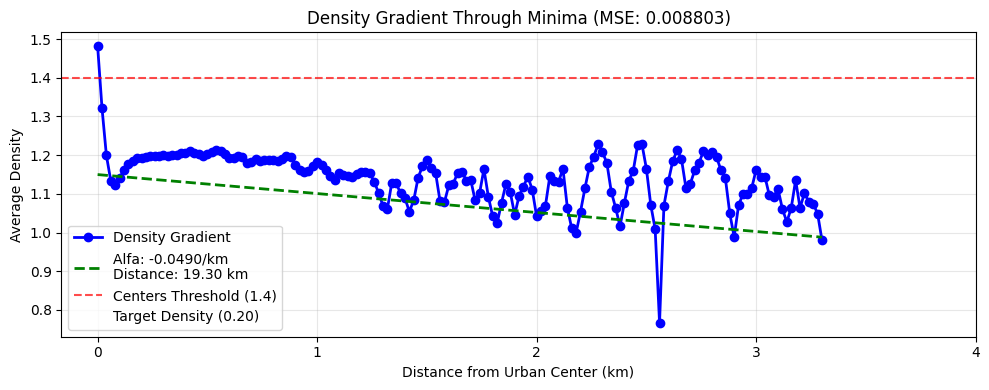

In [6]:
# Set gradient_intercept to the minimum of the urban density
gradient_intercept = urban_density.min()

# Calculate density gradients from centers
def calculate_density_gradients(centers_mask, urban_mask, density_map):
    """Calculate how density changes with distance from urban centers"""
    # Calculate distance from each urban pixel to the nearest center
    # First invert the centers mask to get distance transform
    centers_dist_transform = distance_transform_edt(~centers_mask)
    
    # Only consider distances within urban areas
    urban_distances = centers_dist_transform[urban_mask]
    urban_densities = density_map[urban_mask]
    
    # Bin distances to create gradient profile
    max_dist = int(np.max(urban_distances)) + 1
    distance_bins = range(max_dist)
    density_by_distance = []
    
    for d in distance_bins:
        # Get densities at this distance
        mask = (urban_distances >= d) & (urban_distances < d+1)
        if np.sum(mask) > 0:
            avg_density = np.mean(urban_densities[mask])
            density_by_distance.append((d, avg_density))
    
    return density_by_distance

# Calculate density gradients
density_gradients = calculate_density_gradients(urban_centers_mask, urban_mask, combined_image)

# Density gradient plot data
distances = [d for d, _ in density_gradients]
densities = [den for _, den in density_gradients]

# Convert to numpy arrays for analysis
distances_np = np.array(distances)
densities_np = np.array(densities)

# Convert pixel distances to kilometers using satellite resolution
distances_km = distances_np * satellite_pixel_resolution / 1000  # Divide by 1000 to convert m to km

# Create a single figure with the density gradient plot
plt.figure(figsize=(10, 4))

# Plot the original density gradient
plt.plot(distances_km, densities_np, 'bo-', linewidth=2, label='Density Gradient')

# Find local centers (bumps/peaks)
if len(distances_np) > 5:
    prominence = 0.02 * (max(densities_np) - min(densities_np))
    peaks, _ = find_peaks(densities_np, prominence=prominence)
    
    # Find local minima (valleys)
    neg_densities = -1 * densities_np
    minima, _ = find_peaks(neg_densities, prominence=prominence)
else:
    peaks = []
    minima = []

# Skip the first point - don't add it to minima
# Add only last point if needed
if (len(distances_np)-1) not in peaks and (len(distances_np)-1) not in minima:
    minima = np.append(minima, np.array([len(distances_np)-1]))

# Sort minima to ensure they're in ascending order
minima = np.sort(minima)

# Calculate linear regression through minima
if len(minima) > 1:
    # Use scipy_stats to avoid conflicts with any existing 'stats' variable
    slope_pixel, intercept, r_value, p_value, std_err = scipy_stats.linregress(
        distances_np[minima], densities_np[minima])
    
    # Calculate slope in terms of km
    slope_km = slope_pixel * 1000 / satellite_pixel_resolution  # Convert to per-km
    
    # Create trendline for all points
    trendline = slope_pixel * distances_np + intercept
    
    # Define the y-value for which to calculate the intercept
    target_y_value = gradient_intercept  # Example value - adjust as needed
    
    # Calculate x-value where the line intersects target_y_value
    if abs(slope_pixel) > 1e-10:  # Avoid division by near-zero
        x_pixels_at_target_y = (target_y_value - intercept) / slope_pixel
        ld_distance_min_km = x_pixels_at_target_y * satellite_pixel_resolution / 1000  # Convert to km
    else:
        x_pixels_at_target_y = float('inf')  # If slope is essentially zero
        ld_distance_min_km = float('inf')
    
    # Plot trendline
    plt.plot(distances_km, trendline, 'g--', linewidth=2, 
             label=f'Alfa: {slope_km:.4f}/km\nDistance: {ld_distance_min_km:.2f} km')
    
    # Calculate MSE between actual and trendline
    mse = mean_squared_error(densities_np, trendline)
else:
    mse = 0
    ld_distance_min_km = float('inf')

# Add horizontal line at center threshold
plt.axhline(y=urban_center_threshold, color='r', linestyle='--', alpha=0.7, label=f"Centers Threshold ({urban_center_threshold})")

# Add target density to legend without drawing a line
plt.plot([], [], ' ', label=f"Target Density ({target_y_value:.2f})")

# If the intercept is within the plot range, mark it
if 0 <= ld_distance_min_km <= max(distances_km):
    plt.axvline(x=ld_distance_min_km, color='m', linestyle=':', alpha=0.5)
    plt.plot(ld_distance_min_km, target_y_value, 'mo', markersize=8)

# Set x-axis ticks using the defined interval
max_distance_km = np.ceil(max(distances_km))
x_ticks = np.arange(0, max_distance_km + 1, gradient_x_tick_interval/1000)  # Convert m to km
plt.xticks(x_ticks)
plt.grid(True, alpha=0.3)

plt.xlabel('Distance from Urban Center (km)')
plt.ylabel('Average Density')
plt.title(f'Density Gradient Through Minima (MSE: {mse:.6f})')
plt.legend()

# Make the plot have good proportions
plt.tight_layout()
plt.savefig(f'data/{base_name}_urban_density_gradient.png', dpi=300)
plt.show()

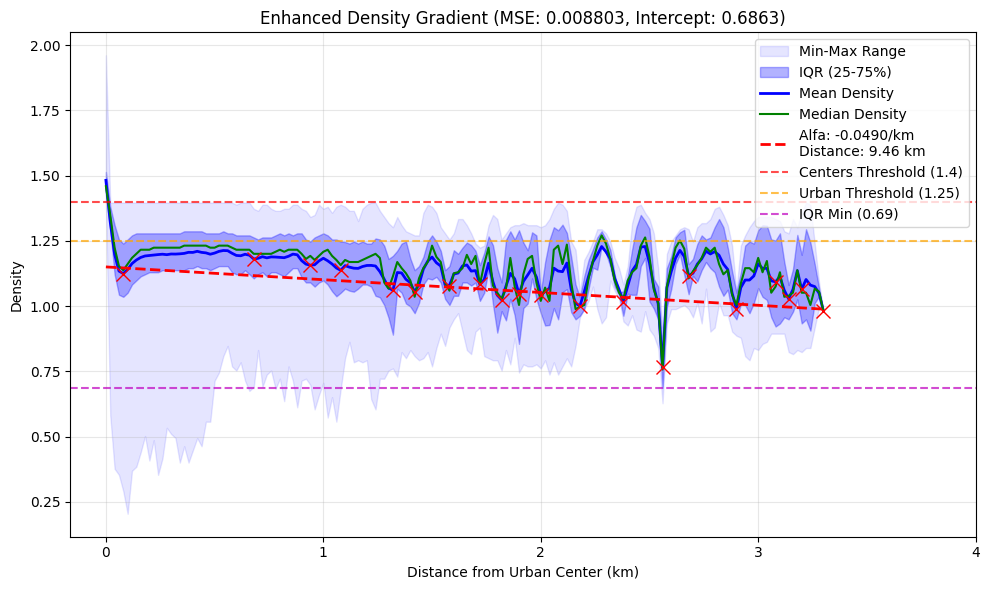

In [7]:
# Calculate density gradients from centers
def calculate_enhanced_density_gradients(centers_mask, urban_mask, density_map):
    """Calculate how density changes with distance from urban centers with enhanced statistics"""
    # Calculate distance from each urban pixel to the nearest center
    centers_dist_transform = distance_transform_edt(~centers_mask)
    
    # Only consider distances within urban areas
    urban_distances = centers_dist_transform[urban_mask]
    urban_densities = density_map[urban_mask]
    
    # Bin distances to create gradient profile with enhanced statistics
    max_dist = int(np.max(urban_distances)) + 1
    distance_bins = range(max_dist)
    density_stats_by_distance = []
    
    for d in distance_bins:
        # Get densities at this distance
        mask = (urban_distances >= d) & (urban_distances < d+1)
        if np.sum(mask) > 0:
            densities_at_d = urban_densities[mask]
            stats = {
                "distance": d,
                "min": np.min(densities_at_d),
                "q1": np.percentile(densities_at_d, 25),
                "median": np.median(densities_at_d),
                "mean": np.mean(densities_at_d),
                "q3": np.percentile(densities_at_d, 75),
                "max": np.max(densities_at_d)
            }
            density_stats_by_distance.append(stats)
    
    return density_stats_by_distance

# Calculate enhanced density gradients
density_stats = calculate_enhanced_density_gradients(urban_centers_mask, urban_mask, combined_image)

# Extract data for plotting - ensure all arrays are created from the same source
distances = np.array([stat["distance"] for stat in density_stats])
mean_densities = np.array([stat["mean"] for stat in density_stats])
median_densities = np.array([stat["median"] for stat in density_stats])
min_densities = np.array([stat["min"] for stat in density_stats])
max_densities = np.array([stat["max"] for stat in density_stats])
q1_densities = np.array([stat["q1"] for stat in density_stats])
q3_densities = np.array([stat["q3"] for stat in density_stats])

# Convert pixel distances to kilometers using satellite resolution
distances_km = distances * satellite_pixel_resolution / 1000  # Divide by 1000 to convert m to km

# Set gradient_intercept to the minimum of the Q1 values (minimum of IQR)
gradient_intercept = np.min(q1_densities)

# Find peaks and minima in the mean density profile
if len(distances) > 5:
    prominence = 0.02 * (np.max(mean_densities) - np.min(mean_densities))
    peaks, _ = find_peaks(mean_densities, prominence=prominence)
    
    # Find local minima (valleys)
    neg_densities = -1 * mean_densities
    minima, _ = find_peaks(neg_densities, prominence=prominence)
else:
    peaks = []
    minima = []

# Skip the first point - don't add it to minima
# Add only last point if needed
if (len(distances)-1) not in peaks and (len(distances)-1) not in minima:
    minima = np.append(minima, np.array([len(distances)-1]))

# Sort minima to ensure they're in ascending order
minima = np.sort(minima)

# Calculate linear regression through minima
if len(minima) > 1:
    slope_pixel, intercept, r_value, p_value, std_err = scipy_stats.linregress(
        distances[minima], mean_densities[minima])
    
    # Calculate slope in terms of km
    slope_km = slope_pixel * 1000 / satellite_pixel_resolution  # Convert to per-km
    
    # Create trendline for all points
    trendline = slope_pixel * distances + intercept
    
    # Calculate x-value where the line intersects target_y_value
    if abs(slope_pixel) > 1e-10:  # Avoid division by near-zero
        x_pixels_at_target_y = (gradient_intercept - intercept) / slope_pixel
        ld_distance_irq_km = x_pixels_at_target_y * satellite_pixel_resolution / 1000  # Convert to km
    else:
        x_pixels_at_target_y = float('inf')  # If slope is essentially zero
        ld_distance_irq_km = float('inf')
    
    # Calculate MSE between actual and trendline
    mse = mean_squared_error(mean_densities, trendline)
else:
    mse = 0
    ld_distance_irq_km = float('inf')
    slope_km = 0
    intercept = 0
    trendline = np.zeros_like(distances)

# Create enhanced density gradient plot
plt.figure(figsize=(10, 6))

# Plot density ranges
plt.fill_between(distances_km, min_densities, max_densities, alpha=0.1, color='blue', label='Min-Max Range')
plt.fill_between(distances_km, q1_densities, q3_densities, alpha=0.3, color='blue', label='IQR (25-75%)')

# Plot average and median lines
plt.plot(distances_km, mean_densities, 'b-', linewidth=2, label='Mean Density')
plt.plot(distances_km, median_densities, 'g-', linewidth=1.5, label='Median Density')

# Add the trendline
if len(minima) > 1:
    plt.plot(distances_km, trendline, 'r--', linewidth=2, 
             label=f'Alfa: {slope_km:.4f}/km\nDistance: {ld_distance_irq_km:.2f} km')

# Add horizontal lines for thresholds
plt.axhline(y=urban_center_threshold, color='r', linestyle='--', alpha=0.7, 
           label=f"Centers Threshold ({urban_center_threshold})")
plt.axhline(y=urban_threshold, color='orange', linestyle='--', alpha=0.7, 
           label=f"Urban Threshold ({urban_threshold})")
plt.axhline(y=gradient_intercept, color='m', linestyle='--', alpha=0.7, 
           label=f"IQR Min ({gradient_intercept:.2f})")

# Mark minima points used for regression
plt.plot(distances_km[minima], mean_densities[minima], 'rx', markersize=10)

# If the intercept is within the plot range, mark it
if 0 <= ld_distance_irq_km <= max(distances_km):
    plt.axvline(x=ld_distance_irq_km, color='m', linestyle=':', alpha=0.5)
    plt.plot(ld_distance_irq_km, gradient_intercept, 'mo', markersize=8)

# Set x-axis ticks using the defined interval
max_distance_km = np.ceil(max(distances_km))
x_ticks = np.arange(0, max_distance_km + 1, gradient_x_tick_interval/1000)  # Convert m to km
plt.xticks(x_ticks)

plt.xlabel('Distance from Urban Center (km)')
plt.ylabel('Density')
plt.title(f'Enhanced Density Gradient (MSE: {mse:.6f}, Intercept: {gradient_intercept:.4f})')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()

# Save and display the plot
plt.savefig(f'data/{base_name}_enhanced_density_gradient.png', dpi=300)
plt.show()

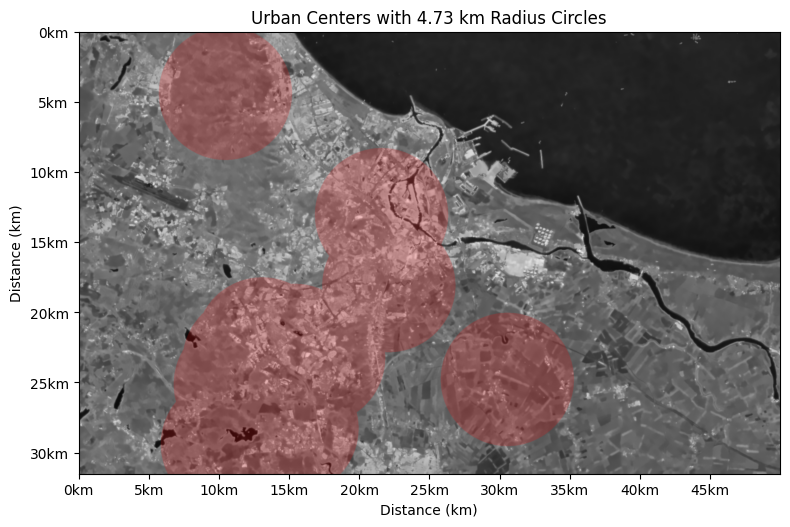

In [8]:
# Define distance for circle radius
ld_distance_km = ld_distance_irq_km / 2

# Define center sizse selection for plots
center_min_size = 300
center_max_size = 400

# Find centers of urban center clusters
num_centers, center_labels, center_stats, center_centroids = cv2.connectedComponentsWithStats(
    urban_centers_mask.astype(np.uint8), connectivity=8)

# Convert combined image to a grayscale background
# Normalize to 0-255 range
background_image = np.clip(combined_image * 255 / combined_image.max(), 0, 255).astype(np.uint8)
# Convert to 3-channel grayscale image for colored overlays
background_image_rgb = cv2.cvtColor(background_image, cv2.COLOR_GRAY2RGB)

# Create a copy for drawing
result_image = background_image_rgb.copy()

# Create a separate mask for all circles
circles_mask = np.zeros_like(result_image)
radius_pixels = int(ld_distance_km * 1000 / satellite_pixel_resolution)  # Convert km to pixels

# Define red color in RGB format for consistency with matplotlib
red_color = (255, 0, 0)  # This is RED in RGB format

# Draw all circles on the circles mask
for i in range(1, num_centers):
    # Skip clusters not in the desired size range
    if (center_stats[i, cv2.CC_STAT_AREA] < center_min_size) or (center_stats[i, cv2.CC_STAT_AREA] > center_max_size):
        continue
        
    # Get center coordinates and convert to integers
    center_y, center_x = center_centroids[i]
    center = (int(center_x), int(center_y))
    
    # Draw a filled circle on the circles mask (solid red)
    cv2.circle(circles_mask, center, radius_pixels, red_color, -1)  # Red filled circle
    
    # Draw circle boundary in red (same color as fill)
    cv2.circle(circles_mask, center, radius_pixels, red_color, 2)  # Red border

# Now combine the background and circles with proper alpha
# Create binary mask where circles exist
binary_mask = (circles_mask > 0).any(axis=2)
# Apply the circles with alpha=0.2 only where circles exist
alpha = 0.2
result_image[binary_mask] = cv2.addWeighted(
    circles_mask[binary_mask], 
    alpha, 
    result_image[binary_mask], 
    1 - alpha, 
    0
)

# Convert to BGR for saving with cv2.imwrite
result_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
cv2.imwrite(f'data/{base_name}_urban_centers_circles_gray.png', result_image_bgr)

# Display using matplotlib (which expects RGB)
plt.figure(figsize=(8, 7))
plt.imshow(result_image)
set_axes_in_meters(plt.gca(), result_image.shape)
plt.title(f'Urban Centers with {ld_distance_km:.2f} km Radius Circles')
plt.tight_layout()
plt.show()